In [ ]:
#default_exp learner
from nbdev.showdoc import show_doc

# Ensemble Learner

> Implements functions necessary to build an  `EnsembleLearner` suitable for bioimgage segmentation

In [ ]:
#hide
import imageio
from scipy import ndimage
from fastcore.test import *

In [ ]:
#export
import shutil, gc, joblib, json, zarr, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass, field, asdict
from pathlib import Path

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

from fastprogress import progress_bar
from fastcore.basics import patch, GetAttr
from fastcore.foundation import add_docs, L
from fastai import optimizer
from fastai.torch_core import TensorImage
from fastai.learner import Learner
from fastai.callback.tracker import SaveModelCallback
from fastai.data.core import DataLoaders
from fastai.data.transforms import get_image_files, get_files, Normalize
from fastai.vision.augment import Brightness, Contrast, Saturation
from fastai.losses import CrossEntropyLossFlat

from deepflash2.metrics import Dice_f1, Iou
from deepflash2.losses import WeightedSoftmaxCrossEntropy,load_kornia_loss
from deepflash2.callbacks import ElasticDeformCallback
from deepflash2.models import get_default_shapes, load_smp_model
from deepflash2.data import TileDataset, RandomTileDataset, _read_img, _read_msk
from deepflash2.utils import iou, plot_results, get_label_fn, calc_iterations, save_mask, save_unc, compose_albumentations
from deepflash2.utils import compose_albumentations as _compose_albumentations
import deepflash2.tta as tta
from deepflash2.transforms import WeightTransform, calculate_weights

## Config

In [ ]:
#export
@dataclass
class Config:
    "Config class for settings."

    # Project
    proj_dir:str = 'deepflash2'

    # GT Estimation Settings
    staple_thres:float = 0.5
    staple_fval:int= 1
    mv_undec:int = 0

    # Train General Settings
    n:int = 4
    max_splits:int=5
    repo:str = 'matjesg/deepflash2'
    arch:str = 'unext50_deepflash2'
    pretrained:str = None
    random_state:int = 42
        
    # Pytorch Segmentation Model Settings
    encoder_name:str = 'efficientnet-b4'
    encoder_weights:str = 'imagenet'

    # Train Data Settings
    c:int = 2
    il:bool = False

    # Train Settings
    lr:float = 0.001
    bs:int = 4
    wd:float = 0.001
    mpt:bool = False
    optim:str = 'ranger'
    loss:str = 'WeightedSoftmaxCrossEntropy'
    n_iter:int = 1000

    # Validation and Prediction Settings
    tta:bool = True
    border_padding_factor:float = 0.25
    shift:float = 0.5

    # Train Data Augmentation
    CLAHE_clip_limit:float = 0.0
    brightness_limit:float = 0.0
    contrast_limit:float = 0.0
    zoom_sigma:float = 0.0
    flip:bool = True
    rot:int = 360
    deformation_grid:int = 150
    deformation_magnitude:int = 10
        
    # Loss Settings Kornia
    loss_alpha:float = 0.5 # Twerksky/Focal loss
    loss_beta:float = 0.5 # Twerksy Loss
    loss_gamma:float = 2.0 # Focal loss
    
    # Loss Mask Weights (WeightedSoftmaxCrossEntropy)
    bwf:int = 25
    bws:int = 10
    fds:int = 10
    fbr:float = 0.5

    # Pred Settings
    pred_tta:bool = True

    # OOD Settings
    kernel:str = 'rbf'
    nu:float = 0.01
    gamma:float = 0.01
    energy_ks:int = 20

    # Folder Structure
    gt_dir:str = 'GT_Estimation'
    train_dir:str = 'Training'
    pred_dir:str = 'Prediction'
    ens_dir:str = 'ensemble'
    val_dir:str = 'valid'

    @property
    def mw_kwargs(self):
        kwargs = ['bwf', 'bws', 'fds', 'fbr']
        return dict(filter(lambda x: x[0] in kwargs, self.__dict__.items()))
    
    @property
    def albumentation_kwargs(self):
        kwargs = ['CLAHE_clip_limit', 'brightness_limit', 'contrast_limit']
        return dict(filter(lambda x: x[0] in kwargs, self.__dict__.items()))

    @property
    def svm_kwargs(self):
        svm_vars = ['kernel', 'nu', 'gamma']
        return dict(filter(lambda x: x[0] in svm_vars, self.__dict__.items()))

    def save(self, path):
        'Save configuration to path'
        path = Path(path)
        with open(path.with_suffix('.json'), 'w') as config_file:
            json.dump(asdict(self), config_file)
        print(f'Saved current configuration to {path}.json')

    def load(self, path):
        'Load configuration from path'
        path = Path(path)
        try:
            with open(path) as config_file: c = json.load(config_file)
            if not Path(c['proj_dir']).is_dir(): c['proj_dir']='deepflash2'
            for k,v in c.items(): setattr(self, k, v)
            print(f'Successsfully loaded configuration from {path}')
        except:
            print('Error! Select valid config file (.json)')

In [ ]:
t1 = Config(n=3)
t1.save('test_config')
t2 = Config()
t2.load('test_config.json')
test_eq(t1, t2)

Saved current configuration to test_config.json
Successsfully loaded configuration from test_config.json


In [ ]:
#export
_optim_dict = {
    'ranger' : optimizer.ranger,
    'Adam' : optimizer.Adam,
    'RAdam' : optimizer.RAdam,
    'QHAdam' :optimizer.QHAdam,
    'Larc' : optimizer.Larc,
    'Lamb' : optimizer.Lamb,
    'SGD' : optimizer.SGD,
    'RMSProp' : optimizer.RMSProp,
}

## Patches for the `fastai` Learner

In [ ]:
#export
@patch
def apply_dropout(self:Learner):
    "If a module contains 'dropout', it will be switched to .train() mode."
    for m in self.model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

In [ ]:
#export
def energy_max(e, ks=20, dim=None):
    e = torch.as_tensor(e).resize_((1,1,*e.shape))
    e = F.avg_pool2d(e, ks)
    return torch.max(e)

In [ ]:
e = np.random.randn(1024,1024)
test_close(energy_max(e, ks=100),0, eps=1e-01)

In [ ]:
#export
# from https://github.com/MIC-DKFZ/nnUNet/blob/2fade8f32607220f8598544f0d5b5e5fa73768e5/nnunet/network_architecture/neural_network.py#L250
def _get_gaussian(patch_size, sigma_scale=1. / 8) -> np.ndarray:
    tmp = np.zeros(patch_size)
    center_coords = [i // 2 for i in patch_size]
    sigmas = [i * sigma_scale for i in patch_size]
    tmp[tuple(center_coords)] = 1
    gaussian_importance_map = gaussian_filter(tmp, sigmas, 0, mode='constant', cval=0)
    gaussian_importance_map = gaussian_importance_map / np.max(gaussian_importance_map) * 1
    gaussian_importance_map = gaussian_importance_map.astype(np.float32)

    # gaussian_importance_map cannot be 0, otherwise we may end up with nans!
    gaussian_importance_map[gaussian_importance_map == 0] = np.min(
        gaussian_importance_map[gaussian_importance_map != 0])

    return gaussian_importance_map

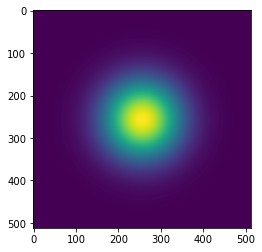

In [ ]:
x = _get_gaussian((512,512))
plt.imshow(x)
plt.show()

In [ ]:
#export
@patch
def predict_tiles(self:Learner, ds_idx=1, dl=None, path=None, mc_dropout=False, n_times=1, use_tta=True, verbose=0,
                       tta_merge='mean', tta_tfms=None, uncertainty_estimates=True, energy_T=1, merge='gauss'):
    "Make predictions and reconstruct tiles, optional with dropout and/or tta applied."

    if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
    assert isinstance(dl.dataset, TileDataset), "Provide dataloader containing a TileDataset"
    if use_tta: 
        tfms = tta_tfms or [tta.HorizontalFlip(), tta.VerticalFlip()] #tta.Rotate90(angles=[90,180,270])
        if verbose>0: print('Using Test-Time Augmentation with:', tfms)
    else: tfms=[]
        
    if merge == 'gauss':
        merge_map = _get_gaussian(dl.output_shape)
    elif merge == 'mean':
        merge_map = np.ones(dl.output_shape)
    else:
        raise NotImplementedError("Use 'gauss' or 'mean' for merge function.")
    mm = torch.from_numpy(merge_map)

    self.model.eval()
    if mc_dropout: self.apply_dropout()
  
    store = str(path) if path else zarr.storage.TempStore()
    root = zarr.group(store=store, overwrite=True)
    g_smx, g_seg, g_std, g_eng, g_wgt  = root.create_groups('smx', 'seg', 'std', 'energy', 'wgt')
    active = ['smx', 'std', 'eng', 'wgt'] if uncertainty_estimates else ['smx', 'wgt']
    
    i = 0
    last_file = None
    if verbose>0: print(f'Starting prediction with overlapping tiles (shift factor {dl.shift})...')
    for data in progress_bar(dl, leave=False):
        if isinstance(data, TensorImage): images = data
        else: images, _, _ = data
        mm = mm.to(images)
        m_smx = tta.Merger()
        m_energy = tta.Merger()
        out_list_smx = []
        for t in tta.Compose(tfms):
            for _ in range(n_times):
                aug_images = t.augment_image(images)
                with torch.no_grad():
                    out = self.model(aug_images)
                out = t.deaugment_mask(out)
                if dl.padding[0]!= images.shape[-1]-out.shape[-1]: 
                    padding = ((images.shape[-1]-out.shape[-1]-dl.padding[0])//2,)*4
                    out = F.pad(out, padding)  
                if dl.c==1:
                    out_act = torch.sigmoid(out)
                    out_act = torch.cat([(1-out_act), out_act], dim=1)
                else:
                    out_act = F.softmax(out, dim=1)
                m_smx.append(out_act)
                if uncertainty_estimates:
                    e = (energy_T*torch.logsumexp(out/energy_T, dim=1)) #negative energy score
                    m_energy.append(e)
        
        ll = []
        batch_smx = m_smx.result()*mm.view(1,1,*mm.shape)
        ll.append([x for x in batch_smx.permute(0,2,3,1).cpu().numpy()])
        
        if uncertainty_estimates:
            batch_std = torch.mean(m_smx.result('std'), 1)*mm.view(1,*mm.shape)
            ll.append([x for x in batch_std.cpu().numpy()])
            
            batch_energy =  m_energy.result()*mm.view(1,*mm.shape)
            ll.append([x for x in batch_energy.cpu().numpy()])
        
        for j, preds in enumerate(zip(*ll)):
            if len(preds)==3: smx,std,eng = preds
            else: smx = preds[0]
            idx = i+j
            f = dl.files[dl.image_indices[idx]]
            outShape = dl.image_shapes[idx]
            outSlice = dl.out_slices[idx]
            inSlice = dl.in_slices[idx]
            if last_file!=f: 
                z_smx = g_smx.zeros(f.name, shape=(*outShape, max(2, dl.c)), dtype='float32')
                z_std = g_std.zeros(f.name, shape=outShape, dtype='float32')
                z_eng = g_eng.zeros(f.name, shape=outShape, dtype='float32')
                z_wgt = g_wgt.zeros(f.name, shape=outShape, dtype='float32')
                last_file = f
            z_smx[outSlice] += smx[inSlice]
            z_wgt[outSlice] += merge_map[inSlice]
            if uncertainty_estimates:
                z_std[outSlice] += std[inSlice]
                z_eng[outSlice] += eng[inSlice]
        i += dl.bs
        
    if verbose>0: print(f'Merging predictions with {merge} weights...')
    for k in progress_bar(g_smx, leave=False):
        wgt = g_wgt[k][:]
        smx_norm = g_smx[k][:] / wgt[..., np.newaxis]
        g_smx[k] = smx_norm
        g_seg[k] = np.argmax(smx_norm, axis=-1)
        if uncertainty_estimates:
            g_std[k] /= wgt
            g_eng[k] /= wgt
            
    return g_smx, g_seg, g_std, g_eng

In [ ]:
#hide
class TestModel(torch.nn.Module):
    def __init__(self, channels=2, padding=None):
        super().__init__()
        self.padding = padding
        self.channels = channels
    def forward(self, inp):
        if self.padding:
            inp = F.pad(inp, (-self.padding//2,)*4)
        if self.channels==1: return inp
        else: return torch.cat([(inp*-1), inp], dim=1)

In [ ]:
mask = (np.random.rand(1024,1024)>0.5).astype('uint8')
imageio.imsave('tst_msk.png', mask)
files = [Path('tst_msk.png')]
model = TestModel(padding=50)
ds_kwargs = {'tile_shape':(512,512), 'padding':(76,76), 'scale':1, 'shift':0.8}
ds = TileDataset(files, **ds_kwargs)
dls = DataLoaders.from_dsets(ds, batch_size=4, shuffle=False, drop_last=False)
learn = Learner(dls, model, loss_func='')
g_smx, g_seg, g_std, g_eng = learn.predict_tiles(dl=dls.train, merge='gauss', verbose=1)
out = g_seg[files[0]][:]
test_eq(mask, out)

Using Test-Time Augmentation with: [<deepflash2.tta.HorizontalFlip object at 0x7f2679f9a1f0>, <deepflash2.tta.VerticalFlip object at 0x7f2591154cd0>]
Starting prediction with overlapping tiles (shift factor {dl.shift})...


Merging predictions with gauss weights...


In [ ]:
model = TestModel(padding=50, channels=1)
ds_kwargs = {'tile_shape':(256,256), 'padding':(76,76), 'scale':1, 'shift':1, 'n_classes':1}
ds = TileDataset(files, **ds_kwargs)
dls = DataLoaders.from_dsets(ds, batch_size=4, shuffle=False, drop_last=False)
learn = Learner(dls, model, loss_func='')
g_smx, g_seg, g_std, g_eng = learn.predict_tiles(dl=dls.train)
out = g_seg[files[0]][:]
test_eq(mask, out)

## Ensemble Learner

In [ ]:
#export
class EnsembleLearner(GetAttr):
    _default = 'config' 
    def __init__(self, image_dir='images', mask_dir=None, config=None, path=None, ensemble_dir=None, item_tfms=None,
                 label_fn=None, metrics=None, cbs=None, ds_kwargs={}, dl_kwargs={}, model_kwargs={}, stats=None, files=None):

        self.config = config or Config()
        self.stats = stats 
        self.dl_kwargs = dl_kwargs
        self.model_kwargs = model_kwargs
        self.add_ds_kwargs = ds_kwargs
        self.item_tfms = item_tfms
        self.path = Path(path) if path is not None else Path('.')
        self.metrics = metrics or [Iou(), Dice_f1()]
        self.loss_fn = self.get_loss()
        self.cbs = cbs or [SaveModelCallback(monitor='iou'), ElasticDeformCallback] #ShowGraphCallback
        self.ensemble_dir = ensemble_dir or self.path/'ensemble'    
        
        self.files = L(files) or get_image_files(self.path/image_dir, recurse=False)
        assert len(self.files)>0, f'Found {len(self.files)} images in "{image_dir}". Please check your images and image folder'
        if any([mask_dir, label_fn]):
            if label_fn: self.label_fn = label_fn
            else: self.label_fn = get_label_fn(self.files[0], self.path/mask_dir)
            #Check if corresponding masks exist
            mask_check = [self.label_fn(x).exists() for x in self.files]
            chk_str = f'Found {len(self.files)} images in "{image_dir}" and {sum(mask_check)} masks in "{mask_dir}".'
            assert len(self.files)==sum(mask_check) and len(self.files)>0, f'Please check your images and masks (and folders). {chk_str}'
            print(chk_str)
                  
        else:
            self.label_fn = label_fn
        self.n_splits=min(len(self.files), self.max_splits)
          
        self.models = {}
        self.recorder = {}
        self._set_splits()
        self.ds = RandomTileDataset(self.files, label_fn=self.label_fn, **self.mw_kwargs, **self.ds_kwargs)
        self.in_channels = self.ds.get_data(max_n=1)[0].shape[-1]
        self.df_val, self.df_ens, self.df_model, self.ood = None,None,None,None
    
    @property
    def out_size(self):
        return self.ds_kwargs['tile_shape'][0]-self.ds_kwargs['padding'][0]
           
    def _set_splits(self):
        if self.n_splits>1:
            kf = KFold(self.n_splits, shuffle=True, random_state=self.random_state)
            self.splits = {key:(self.files[idx[0]], self.files[idx[1]]) for key, idx in zip(range(1,self.n_splits+1), kf.split(self.files))}    
        else:
            self.splits = {1: (self.files[0], self.files[0])}
            
    def compose_albumentations(self, **kwargs):
        return _compose_albumentations(**kwargs)
    
    @property        
    def ds_kwargs(self):
        # Setting default shapes and padding
        ds_kwargs = self.add_ds_kwargs.copy()
        for key, value in get_default_shapes(self.arch).items():
            ds_kwargs.setdefault(key, value)
        # Settings from config
        ds_kwargs['n_classes']= self.c
        ds_kwargs['shift']= 1.
        ds_kwargs['border_padding_factor']= 0.
        ds_kwargs['loss_weights'] = True if self.loss=='WeightedSoftmaxCrossEntropy' else False
        ds_kwargs['zoom_sigma'] = self.zoom_sigma
        ds_kwargs['flip'] = self.flip
        ds_kwargs['deformation_grid']= (self.deformation_grid,)*2
        ds_kwargs['deformation_magnitude'] = (self.deformation_magnitude,)*2
        if sum(self.albumentation_kwargs.values())>0: 
            ds_kwargs['albumentation_tfms'] = self.compose_albumentations(**self.albumentation_kwargs)
        return ds_kwargs
    
    @property        
    def pred_ds_kwargs(self):
        # Setting default shapes and padding
        ds_kwargs = self.add_ds_kwargs.copy()
        for key, value in get_default_shapes(self.arch).items():
            ds_kwargs.setdefault(key, value)
        ds_kwargs['n_classes']= self.c
        ds_kwargs['shift']= self.shift
        ds_kwargs['border_padding_factor']= self.border_padding_factor
        return ds_kwargs
            
            
    def get_loss(self):
        if self.loss == 'WeightedSoftmaxCrossEntropy': return WeightedSoftmaxCrossEntropy(axis=1)
        if self.loss == 'CrossEntropyLoss': return CrossEntropyLossFlat(axis=1)
        else: 
            kwargs = {'alpha':self.loss_alpha, 'beta':self.loss_beta, 'gamma':self.loss_gamma}
            return load_kornia_loss(self.loss, **kwargs)
            
    def get_model(self, pretrained):
        if self.arch in ["unet_deepflash2",  "unet_falk2019", "unet_ronnberger2015", "unet_custom", "unext50_deepflash2"]:
            model = torch.hub.load(self.repo, self.arch, pretrained=pretrained, n_classes=self.c, in_channels=self.in_channels, **self.model_kwargs)
        else:
            kwargs = dict(encoder_name=self.encoder_name, encoder_weights=self.encoder_weights, 
                          in_channels=self.in_channels, classes=self.c, **self.model_kwargs)
            model = load_smp_model(self.arch, **kwargs)
        if torch.cuda.is_available(): model.cuda()
        return model
    
    def get_dls(self, files, files_val=None):
        ds = []
        ds.append(RandomTileDataset(files, label_fn=self.label_fn, **self.mw_kwargs, **self.ds_kwargs))
        if files_val: 
            ds.append(TileDataset(files_val, label_fn=self.label_fn, **self.mw_kwargs,**self.ds_kwargs))
        else:
            ds.append(ds[0])
        dls = DataLoaders.from_dsets(*ds, bs=self.bs, after_item=self.item_tfms, after_batch=self.get_batch_tfms(), **self.dl_kwargs)
        if torch.cuda.is_available(): dls.cuda()
        return dls
        
    def save_model(self, file, model, pickle_protocol=2):
        state = model.state_dict()
        state = {'model': state, 'arch':self.arch, 'stats':self.stats, 'c':self.c}
        if self.arch in ["unet_deepflash2",  "unet_falk2019", "unet_ronnberger2015", "unet_custom", "unext50_deepflash2"]:
            state['repo']=self.repo
        else:
            state['encoder_name']=self.encoder_name
        torch.save(state, file, pickle_protocol=pickle_protocol, _use_new_zipfile_serialization=False)
    
    def load_model(self, file, with_meta=True, device=None, strict=True):
        if isinstance(device, int): device = torch.device('cuda', device)
        elif device is None: device = 'cpu'
        state = torch.load(file, map_location=device)
        hasopt = 'model' in state#set(state)=={'model', 'arch', 'repo', 'stats', 'c'}
        if hasopt:
            model_state = state['model']
            if with_meta:
                for opt in state:
                    if opt!='model': setattr(self.config, opt, state[opt])            
        else:
            model_state = state                
        model = self.get_model(pretrained=None)
        model.load_state_dict(model_state, strict=strict)
        return model
    
    def get_batch_tfms(self):
        self.stats = self.stats or self.ds.compute_stats()
        tfms = [Normalize.from_stats(*self.stats)]
        if isinstance(self.loss_fn, WeightedSoftmaxCrossEntropy):
            tfms.append(WeightTransform(self.out_size, **self.mw_kwargs))
        return tfms
        
    def fit(self, i, n_iter=None, lr_max=None, **kwargs):
        n_iter = n_iter or self.n_iter
        lr_max = lr_max or self.lr
        name = self.ensemble_dir/f'{self.arch}_model-{i}.pth'
        pre = None if self.pretrained=='new' else self.pretrained
        model = self.get_model(pretrained=pre)
        files_train, files_val = self.splits[i]
        dls = self.get_dls(files_train, files_val)    
        self.learn = Learner(dls, model, metrics=self.metrics, wd=self.wd, loss_func=self.loss_fn, opt_func=_optim_dict[self.optim], cbs=self.cbs)
        self.learn.model_dir = self.ensemble_dir.parent/'.tmp'
        if self.mpt: self.learn.to_fp16()
        print(f'Starting training for {name.name}')
        epochs = calc_iterations(n_iter=n_iter,ds_length=len(dls.train_ds), bs=self.bs)
        self.learn.fit_one_cycle(epochs, lr_max)

        print(f'Saving model at {name}')
        name.parent.mkdir(exist_ok=True, parents=True)
        self.save_model(name, self.learn.model)
        self.models[i]=name
        self.recorder[i]=self.learn.recorder
        #del model
        #gc.collect()
        #torch.cuda.empty_cache()  
        
    def fit_ensemble(self, n_iter, skip=False, **kwargs):
        for i in range(1, self.n+1):
            if skip and (i in self.models): continue
            self.fit(i, n_iter,  **kwargs)
       
    def set_n(self, n):
        for i in range(n, len(self.models)):
            self.models.pop(i+1, None)            
        self.n = n
                 
    def predict(self, files, model_no, path=None, **kwargs):
        model_path = self.models[model_no]
        model = self.load_model(model_path)
        ds = TileDataset(files, **self.pred_ds_kwargs)
        dls = DataLoaders.from_dsets(ds, batch_size=self.bs, after_batch=self.get_batch_tfms(), shuffle=False, drop_last=False, **self.dl_kwargs)
        if torch.cuda.is_available(): dls.cuda()
        learn = Learner(dls, model, loss_func=self.loss_fn)
        if self.mpt: learn.to_fp16()
        if path: path = path/f'model_{model_no}'
        return learn.predict_tiles(dl=dls.train, path=path, **kwargs)
                               
    def get_valid_results(self, model_no=None, export_dir=None, filetype='.png', **kwargs):
        res_list = []
        model_list = self.models if not model_no else [model_no]
        if export_dir: 
            export_dir = Path(export_dir)
            pred_path = export_dir/'masks'
            pred_path.mkdir(parents=True, exist_ok=True)
            if self.tta:
                unc_path = export_dir/'uncertainties'
                unc_path.mkdir(parents=True, exist_ok=True)
        for i in model_list:
            _, files_val = self.splits[i]
            g_smx, g_seg, g_std, g_eng = self.predict(files_val, i, **kwargs)
            chunk_store = g_smx.chunk_store.path
            for j, f in enumerate(files_val):
                msk = self.ds.get_data(f, mask=True)[0]
                pred = g_seg[f.name][:]
                m_iou = iou(msk, pred)
                m_path = self.models[i].name
                m_eng_max = energy_max(g_eng[f.name][:], ks=self.energy_ks)
                df_tmp = pd.Series({'file' : f.name,
                        'model' :  m_path,
                        'model_no' : i,
                        'img_path': f,
                        'iou': m_iou,
                        'energy_max': m_eng_max.numpy(),
                        'msk_path': self.label_fn(f),
                        'pred_path': f'{chunk_store}/{g_seg.path}/{f.name}',
                        'smx_path': f'{chunk_store}/{g_smx.path}/{f.name}',
                        'std_path': f'{chunk_store}/{g_std.path}/{f.name}'})
                res_list.append(df_tmp)
                if export_dir:   
                    save_mask(pred, pred_path/f'{df_tmp.file}_{df_tmp.model}_mask', filetype)
                    if self.tta:
                        save_unc(g_std[f.name][:], unc_path/f'{df_tmp.file}_{df_tmp.model}_unc', filetype)
        self.df_val = pd.DataFrame(res_list)
        if export_dir: 
            self.df_val.to_csv(export_dir/f'val_results.csv', index=False)
            self.df_val.to_excel(export_dir/f'val_results.xlsx')
        return self.df_val
        
    def show_valid_results(self, model_no=None, files=None, **kwargs):
        if self.df_val is None: self.get_valid_results(**kwargs)
        df = self.df_val
        if files is not None: df = df.set_index('file', drop=False).loc[files]
        if model_no is not None: df = df[df.model_no==model_no] 
        for _, r in df.iterrows():
            img = self.ds.get_data(r.img_path)[0][:]
            msk = self.ds.get_data(r.img_path, mask=True)[0]
            pred = zarr.load(r.pred_path)
            std = zarr.load(r.std_path)
            _d_model = f'Model {r.model_no}'
            if self.tta: plot_results(img, msk, pred, std, df=r, model=_d_model)  
            else: plot_results(img, msk, pred, np.zeros_like(pred), df=r, model=_d_model)  
          
    def load_ensemble(self, path=None):
        path = path or self.ensemble_dir
        models = get_files(path, extensions='.pth', recurse=False)
        assert len(models)>0, f'No models found in {path}'
        self.models = {}
        for m in models:
            model_id = int(m.stem[-1])
            self.models[model_id] = m
        print(f'Found {len(self.models)} models in folder {path}')
        print(self.models)
        
            
    def ensemble_results(self, files, path=None, export_dir=None, filetype='.png', use_tta=None, **kwargs):
        use_tta = use_tta or self.pred_tta
        if export_dir: 
            export_dir = Path(export_dir)
            pred_path = export_dir/'masks'
            pred_path.mkdir(parents=True, exist_ok=True)
            if use_tta:
                unc_path = export_dir/'uncertainties'
                unc_path.mkdir(parents=True, exist_ok=True)
        
        store = str(path/'ensemble') if path else zarr.storage.TempStore()
        root = zarr.group(store=store, overwrite=True)
        chunk_store = root.chunk_store.path
        g_smx, g_seg, g_std, g_eng  = root.create_groups('ens_smx', 'ens_seg', 'ens_std', 'ens_energy')
        res_list = []
        for f in files:
            df_fil = self.df_models[self.df_models.file==f.name]
            assert len(df_fil)==len(self.models), "Predictions and models to not match."
            m_smx, m_std, m_eng = tta.Merger(), tta.Merger(), tta.Merger()
            for idx, r in df_fil.iterrows():
                m_smx.append(zarr.load(r.smx_path))
                m_std.append(zarr.load(r.std_path))
                m_eng.append(zarr.load(r.eng_path))
            smx = m_smx.result().numpy()
            g_smx[f.name] = smx
            g_seg[f.name] = np.argmax(smx, axis=-1)
            g_std[f.name] = m_std.result().numpy()
            eng = m_eng.result()
            g_eng[f.name] = eng.numpy()
            m_eng_max = energy_max(eng, ks=self.energy_ks).numpy()
            df_tmp = pd.Series({'file' : f.name,
                                'model' :  f'{self.arch}_ensemble',
                                'energy_max': m_eng_max,
                                'img_path': f,
                                'pred_path': f'{chunk_store}/{g_seg.path}/{f.name}',
                                'smx_path': f'{chunk_store}/{g_smx.path}/{f.name}',
                                'std_path': f'{chunk_store}/{g_std.path}/{f.name}',
                                'eng_path': f'{chunk_store}/{g_eng.path}/{f.name}'})
            res_list.append(df_tmp)
            if export_dir:   
                save_mask(g_seg[f.name][:], pred_path/f'{df_tmp.file}_{df_tmp.model}_mask', filetype)
                if use_tta:
                    save_unc(g_std[f.name][:], unc_path/f'{df_tmp.file}_{df_tmp.model}_unc', filetype)
        return pd.DataFrame(res_list)
                            
    def get_ensemble_results(self, new_files, export_dir=None, filetype='.png', **kwargs):   
        res_list = []
        for i in self.models:
            g_smx, g_seg, g_std, g_eng = self.predict(new_files, i, **kwargs)
            chunk_store = g_smx.chunk_store.path
            for j, f in enumerate(new_files):
                m_path = self.models[i].name
                df_tmp = pd.Series({'file' : f.name,
                                    'model_no': i, 
                                    'model' :  m_path,
                                    'img_path': f,
                                    'pred_path': f'{chunk_store}/{g_seg.path}/{f.name}',
                                    'smx_path': f'{chunk_store}/{g_smx.path}/{f.name}',
                                    'std_path': f'{chunk_store}/{g_std.path}/{f.name}',
                                    'eng_path': f'{chunk_store}/{g_eng.path}/{f.name}'})
                res_list.append(df_tmp)
        self.df_models = pd.DataFrame(res_list)
        self.df_ens  = self.ensemble_results(new_files, export_dir=export_dir, filetype=filetype, **kwargs)
        return self.df_ens
    
    def score_ensemble_results(self, mask_dir=None, label_fn=None):
        if not label_fn:
            label_fn = get_label_fn(self.df_ens.img_path[0], self.path/mask_dir)
        for idx, r in self.df_ens.iterrows():
            msk_path = self.label_fn(r.img_path)
            msk = _read_msk(msk_path)
            self.df_ens.loc[idx, 'msk_path'] = msk_path
            pred = zarr.load(r.pred_path)
            self.df_ens.loc[idx, 'iou'] = iou(msk, pred)
        return self.df_ens
    
    def show_ensemble_results(self, files=None, model_no=None, unc=True, unc_metric=None):
        if self.df_ens is None: assert print("Please run `get_ensemble_results` first.")
        if model_no is None: df = self.df_ens
        else: df = self.df_models[df_models.model_no==model_no]
        if files is not None: df = df.set_index('file', drop=False).loc[files]
        for _, r in df.iterrows():
            imgs = []
            imgs.append(_read_img(r.img_path)[:])
            if 'iou' in r.index: 
                imgs.append(_read_msk(r.msk_path))
                hastarget=True
            else:
                hastarget=False
            imgs.append(zarr.load(r.pred_path))
            if unc: imgs.append(zarr.load(r.std_path))
            plot_results(*imgs, df=r, hastarget=hastarget, unc_metric=unc_metric) 
                
    def lr_find(self, files=None, **kwargs):
        files = files or self.files
        dls = self.get_dls(files)
        pre = None if self.pretrained=='new' else self.pretrained
        model = self.get_model(pretrained=pre)
        learn = Learner(dls, model, metrics=self.metrics, wd=self.wd, loss_func=self.loss_fn, opt_func=_optim_dict[self.optim])
        if self.mpt: learn.to_fp16()
        sug_lrs = learn.lr_find(**kwargs)
        return sug_lrs, learn.recorder  
    
    def show_mask_weights(self, files, figsize=(12,12), **kwargs):
        masks = [self.label_fn(Path(f)) for f in files]
        for m in masks:
            print(self.mw_kwargs)
            print(f'Calculating weights. Please wait...')
            msk = _read_msk(m)
            _, w, _ = calculate_weights(msk, n_dims=self.c, **self.mw_kwargs)
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize, **kwargs)
            axes[0].imshow(msk)
            axes[0].set_axis_off()
            axes[0].set_title(f'Mask {m.name}')
            axes[1].imshow(w)
            axes[1].set_axis_off()
            axes[1].set_title('Weights')
            plt.show()
    
    def ood_train(self, features=['energy_max'], **kwargs):
        self.ood = Pipeline([('scaler', StandardScaler()), ('svm',svm.OneClassSVM(**kwargs))])
        self.ood.fit(self.df_ens[features])     
        
    def ood_score(self, features=['energy_max']):
        self.df_ens['ood_score'] = self.ood.score_samples(self.df_ens[features])
    
    def ood_save(self, path):
        path = Path(path)
        joblib.dump(self.ood, path.with_suffix('.pkl'))
        print(f'Saved OOD model to {path}.pkl')
    
    def ood_load(self, path):
        path = Path(path)
        try:
            self.ood = joblib.load(path)
            print(f'Successsfully loaded OOD Model from {path}')
        except: 
            print('Error! Select valid joblib file (.pkl)') 
    
    def clear_tmp(self):
        try: 
            shutil.rmtree('/tmp/*', ignore_errors=True)
            shutil.rmtree(self.path/'.tmp')
            print(f'Deleted temporary files from {self.path/".tmp"}')
        except: print(f'No temporary files to delete at {self.path/".tmp"}')

In [ ]:
#export
add_docs(EnsembleLearner, "Meta class to train and predict model ensembles with `n` models",
         save_model= "Save `model` to `file` along with `arch`, `stats`, and `c` classes",
         load_model="Load `model` from `file` along with `arch`, `stats`, and `c` classes",
         fit="Fit model number `i`",
         fit_ensemble="Fit `i` models and `skip` existing",
         predict="Predict `files` with model at `model_path`",
         get_valid_results="Validate models on validation data and save results",
         show_valid_results="Plot results of all or `file` validation images",
         ensemble_results="Merge single model results",
         get_ensemble_results="Get models and ensemble results", 
         score_ensemble_results="Compare ensemble results (Intersection over the Union) to given segmentation masks.",
         show_ensemble_results="Show result of ensemble or `model_no`",
         load_ensemble="Get models saved at `path`",
         compose_albumentations="Helper function to compose albumentations augmentations",
         get_dls="Create datasets and dataloaders from files",
         get_model="Get model architecture",
         get_loss="Get loss function from loss name (config)",
         get_batch_tfms="Get transform performed on batch level",
         set_n="Change to `n` models per ensemble",
         lr_find="Wrapper for learning rate finder",
         show_mask_weights='Plot fn for masks and weights',
         ood_train="Train SVM for OOD Detection",
         ood_score="Get OOD score",
         ood_save='Save OOD model to path',
         ood_load='Load OOD model from path',
         clear_tmp="Clear directory with temporary files"
)

In [ ]:
show_doc(EnsembleLearner)

<h2 id="EnsembleLearner" class="doc_header"><code>class</code> <code>EnsembleLearner</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>EnsembleLearner</code>(**`image_dir`**=*`'images'`*, **`mask_dir`**=*`None`*, **`config`**=*`None`*, **`path`**=*`None`*, **`ensemble_dir`**=*`None`*, **`item_tfms`**=*`None`*, **`label_fn`**=*`None`*, **`metrics`**=*`None`*, **`cbs`**=*`None`*, **`ds_kwargs`**=*`{}`*, **`dl_kwargs`**=*`{}`*, **`model_kwargs`**=*`{}`*, **`stats`**=*`None`*, **`files`**=*`None`*) :: `GetAttr`

Meta class to train and predict model ensembles with `n` models

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_learner.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 02a_transforms.ipynb.
Converted 03_metrics.ipynb.
Converted 04_callbacks.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted deepflash2.ipynb.
Converted gt_estimation.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted predict.ipynb.
Converted train.ipynb.
Converted tutorial.ipynb.
